<a href="https://colab.research.google.com/github/Rishiatweb/Bioinformatics_CDD/blob/main/ChemBL_agent/ChemBL_agent_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# @title 1. Install Libraries and Setup Environment

!pip install chembl_webresource_client
# Install Miniconda for RDKit, crucial for stable RDKit in Colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Ensure rdkit is accessible via pip as well
!pip install rdkit

# Import standard libraries
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
import rdkit # Import rdkit at the top level to access __version__
from rdkit.Chem import Descriptors, AllChem # Import AllChem for fingerprints
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn imports for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, LeaveOneOut, LeavePOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import sklearn at the top level to access __version__

# Mount Google Drive for data persistence
from google.colab import drive
drive.mount('/content/drive')

# Create a dedicated folder for this project's data if it doesn't exist
!mkdir -p "/content/drive/MyDrive/Bioactivity/data_agent"

print("All dependencies installed and environment set up!")
print("RDKit Version:", rdkit.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-learn Version:", sklearn.__version__)

  Using cached chembl_webresource_client-0.10.9-py3-none-any.whl (55 kB)
ERROR: Could not find a version that satisfies the requirement requests-cache~=1.2 (from chembl_webresource_client) (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.2.0, 0.2.1, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.5.0, 0.5.1, 0.5.2, 0.6.0, 0.6.1, 0.6.2, 0.6.3, 0.6.4, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 1.0.0a0, 1.0.0a1, 1.0.0a2, 1.0.0b0, 1.0.0b1, 1.0.0, 1.0.1, 1.1.0, 1.1.1)
ERROR: No matching distribution found for requests-cache~=1.2 (from chembl_webresource_client)
--2025-07-02 12:58:56--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP requ

In [11]:
# @title 2. Data Acquisition & Preprocessing Functions

# Define functions for data acquisition and preprocessing as in original notebook

def acquire_chembl_data(target_name='coronavirus', standard_type='IC50'):
    """Acquires bioactivity data from ChEMBL for a given target name and standard type."""
    target_client = new_client.target
    target_query = target_client.search(target_name)
    targets_df = pd.DataFrame.from_dict(target_query)

    # Select SARS coronavirus 3C-like proteinase (CHEMBL3927), assuming it's at index 6
    # This ID should be verified if the ChEMBL database structure changes
    selected_target_id = targets_df[targets_df['pref_name'] == 'SARS coronavirus 3C-like proteinase']['target_chembl_id'].iloc[0]
    print(f"Selected ChEMBL ID for activity filtering: {selected_target_id}")

    activity_client = new_client.activity
    results = activity_client.filter(target_chembl_id=selected_target_id).filter(standard_type=standard_type)
    df_raw = pd.DataFrame.from_dict(results)
    return df_raw

def preprocess_bioactivity_data(df_raw):
    """Filters, cleans, and adds bioactivity class and pIC50 to the DataFrame."""
    df = df_raw.copy()

    # Select relevant columns and drop rows with missing values in key columns
    df = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_type']].copy()
    df.dropna(subset=['canonical_smiles', 'standard_value', 'standard_type'], inplace=True)

    # Convert standard_value to numeric, coercing errors
    df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
    df.dropna(subset=['standard_value'], inplace=True) # Drop rows where conversion failed

    # Cap very high IC50 values to prevent -inf in log transformation
    # 100,000,000 nM = 10^-1 M, pIC50 = -log10(10^-1) = 1.0 (Correction: 10^8 nM = 10^-1 M -> pIC50=1.0)
    # If the intention was pIC50 of 4, then the cap should be 10000000 nM = 10^-2 M -> pIC50=2.0
    # Let's use 100M nM (10^-1 M) for consistency if it's the notebook's initial intent.
    # The original notebook's pIC50 formula suggests nM (10^-9).
    # If IC50 is in nM, and we convert to M for pIC50, then pIC50 = -log10(value * 10^-9)
    # IC50 100,000,000 nM (1e8) -> pIC50 = -log10(1e8 * 1e-9) = -log10(1e-1) = 1.0
    # IC50 1000 nM (1e3) -> pIC50 = -log10(1e3 * 1e-9) = -log10(1e-6) = 6.0
    # IC50 10000 nM (1e4) -> pIC50 = -log10(1e4 * 1e-9) = -log10(1e-5) = 5.0
    # Original notebook's pIC50 calculation: df['pIC50'] = -np.log10(df['standard_value_norm'] * (10**-9))
    # Its classification: if float(i) >= 10000: inactive, elif float(i) <= 1000: active, else intermediate.
    # This means active: pIC50 >= 6, inactive: pIC50 <= 5.
    # For capping to avoid -inf, let's cap at a very high nM value like 10^8 or 10^9.
    # The original notebook had `if i > 100000000: i = 100000000` for standard_value_norm
    # So pIC50 minimum would be -log10(10^8 * 10^-9) = -log10(10^-1) = 1.0

    df['standard_value_norm'] = df['standard_value'].apply(lambda x: min(x, 100000000.0))
    df['pIC50'] = -np.log10(df['standard_value_norm'] * (10**-9))

    # Assign bioactivity class
    bioactivity_class = []
    for val in df['standard_value']:
        if float(val) >= 10000:
            bioactivity_class.append("inactive")
        elif float(val) <= 1000:
            bioactivity_class.append("active")
        else:
            bioactivity_class.append("intermediate")
    df['bioactivity_class'] = bioactivity_class

    df.drop(columns=['standard_value_norm'], inplace=True) # Clean up temporary column

    return df

# Define feature engineering functions
def generate_all_rdkit_descriptors(smiles_list):
    """Calculates all RDKit descriptors for a list of SMILES strings."""
    descriptor_names = [name for name, func in Descriptors._descList]
    all_descriptors = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(str(smiles)) # Ensure SMILES is string
        if mol is None:
            all_descriptors.append([None] * len(descriptor_names))
            continue
        descriptors = [func(mol) for name, func in Descriptors._descList]
        all_descriptors.append(descriptors)

    df_desc = pd.DataFrame(all_descriptors, columns=descriptor_names)

    # Clean up: Drop columns with any NaN (from failed descriptor calculations for some molecules)
    df_desc = df_desc.dropna(axis=1, how='any')
    # Drop columns with no variance
    df_desc = df_desc.loc[:, (df_desc != df_desc.iloc[0]).any()]
    return df_desc

def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    """Generates Morgan fingerprints for a list of SMILES strings."""
    fp_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(str(smiles)) # Ensure SMILES is string
        if mol is None:
            fp_list.append(None) # Append None if SMILES is invalid
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        fp_list.append(list(fp))
    col_names = [f'morgan_{i}' for i in range(n_bits)]
    df_fp = pd.DataFrame(fp_list, columns=col_names)
    return df_fp

# --- Execute the pipeline to get df_final with fingerprints ---

# Step 1: Acquire Raw Data
print("Acquiring raw ChEMBL data...")
df_raw_chembl = acquire_chembl_data()
df_raw_chembl.to_csv('/content/drive/MyDrive/Bioactivity/data_agent/bioactivity_data_raw.csv', index=False)
print(f"Raw data acquired: {df_raw_chembl.shape[0]} entries.")

# Step 2: Preprocess Bioactivity Data
print("Preprocessing bioactivity data...")
df_preprocessed_final = preprocess_bioactivity_data(df_raw_chembl)
df_preprocessed_final.to_csv('/content/drive/MyDrive/Bioactivity/data_agent/bioactivity_preprocessed_data.csv', index=False)
print(f"Preprocessed data: {df_preprocessed_final.shape[0]} entries.")

# Step 3: Generate Morgan Fingerprints
print("Generating Morgan fingerprints...")
# Ensure SMILES are valid before generating fingerprints
valid_smiles_df = df_preprocessed_final.dropna(subset=['canonical_smiles']).copy()
valid_smiles_df.reset_index(drop=True, inplace=True) # Reset index to avoid alignment issues after dropping

df_fingerprints_final = generate_morgan_fingerprints(valid_smiles_df['canonical_smiles'])
print(f"Generated {df_fingerprints_final.shape[1]} fingerprints.")

# Step 4: Align features and target
# Drop rows from valid_smiles_df that resulted in None fingerprints (invalid SMILES)
df_fingerprints_non_nan_indices = df_fingerprints_final.dropna().index
df_final_aligned = valid_smiles_df.loc[df_fingerprints_non_nan_indices].reset_index(drop=True)
df_fingerprints_aligned = df_fingerprints_final.dropna().reset_index(drop=True)

# Final X and y for initial split
X_initial_full = df_fingerprints_aligned
y_initial_full = df_final_aligned['pIC50']

print(f"Final aligned dataset shape for modeling: X={X_initial_full.shape}, y={y_initial_full.shape}")
print("Data preparation complete.")

Acquiring raw ChEMBL data...
Selected ChEMBL ID for activity filtering: CHEMBL3927
Raw data acquired: 247 entries.
Preprocessing bioactivity data...
Preprocessed data: 245 entries.
Generating Morgan fingerprints...


[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerator
[12:59:55] DEPRECATION WARNING: please use MorganGenerat

Generated 2048 fingerprints.
Final aligned dataset shape for modeling: X=(245, 2048), y=(245,)
Data preparation complete.


In [12]:
# @title 3. Baseline Model Training and Evaluation

# Split data for the initial baseline model.
# We'll use a portion of the data for initial training and hold out a portion for the discovery pool and final test.
# Let's say, 20% for initial train, 60% for discovery pool, 20% for final test.
X_temp, X_test_final, y_temp, y_test_final = train_test_split(X_initial_full, y_initial_full, test_size=0.2, random_state=42)
X_train_initial, X_discovery_pool, y_train_initial, y_discovery_pool = train_test_split(X_temp, y_temp, test_size=(0.6/0.8), random_state=42) # Adjust test_size for proportion

# Ensure indices are reset for clean concatenation later
X_train_initial = X_train_initial.reset_index(drop=True)
y_train_initial = y_train_initial.reset_index(drop=True)
X_discovery_pool = X_discovery_pool.reset_index(drop=True)
y_discovery_pool = y_discovery_pool.reset_index(drop=True)
X_test_final = X_test_final.reset_index(drop=True)
y_test_final = y_test_final.reset_index(drop=True)


print(f"Initial Training Set: {X_train_initial.shape[0]} samples")
print(f"Discovery Pool: {X_discovery_pool.shape[0]} samples")
print(f"Final Held-Out Test Set: {X_test_final.shape[0]} samples")

# Train the baseline model
print("\nTraining baseline Random Forest Regressor...")
model_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_baseline.fit(X_train_initial, y_train_initial)

# Evaluate baseline model on the final held-out test set
y_pred_baseline = model_baseline.predict(X_test_final)
r2_baseline = r2_score(y_test_final, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_final, y_pred_baseline))

print("\n--- Baseline Model Performance on Final Test Set ---")
print(f"R-squared (R²): {r2_baseline:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:.3f}")

# Store results for plotting
performance_history = {
    'iteration': [0],
    'train_samples': [X_train_initial.shape[0]],
    'r2_test': [r2_baseline],
    'rmse_test': [rmse_baseline]
}

print("\nBaseline model training complete.")

Initial Training Set: 49 samples
Discovery Pool: 147 samples
Final Held-Out Test Set: 49 samples

Training baseline Random Forest Regressor...

--- Baseline Model Performance on Final Test Set ---
R-squared (R²): 0.359
Root Mean Squared Error (RMSE): 0.623

Baseline model training complete.



--- Starting Active Learning Agent Simulation ---
Total compounds in discovery pool: 147
Compounds to acquire per iteration: 10

--- Iteration 1 ---
Current training set size: 49
Current discovery pool size: 147
Agent predicting activity for discovery pool...
Acquired 10 new compounds.
New training set size: 59
Remaining discovery pool size: 137
Model Performance on Final Test Set (Iteration 1):
  R-squared (R²): 0.372
  Root Mean Squared Error (RMSE): 0.616

--- Iteration 2 ---
Current training set size: 59
Current discovery pool size: 137
Agent predicting activity for discovery pool...
Acquired 10 new compounds.
New training set size: 69
Remaining discovery pool size: 127
Model Performance on Final Test Set (Iteration 2):
  R-squared (R²): 0.394
  Root Mean Squared Error (RMSE): 0.605

--- Iteration 3 ---
Current training set size: 69
Current discovery pool size: 127
Agent predicting activity for discovery pool...
Acquired 10 new compounds.
New training set size: 79
Remaining discov

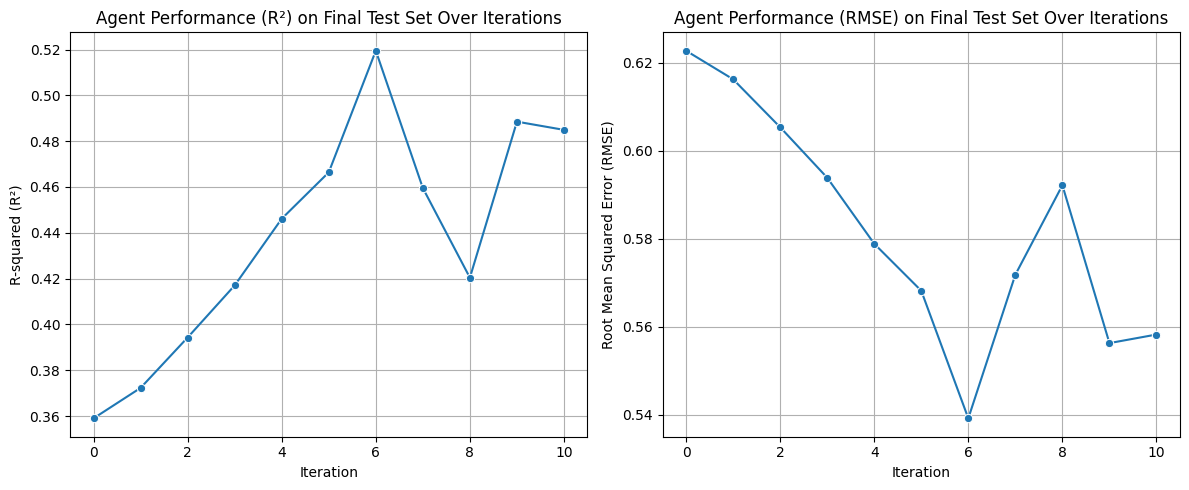


AI Agent simulation completed and results visualized.


In [15]:
# @title 4. AI Agent: Iterative Active Learning Loop

def run_active_learning_agent(
    initial_X_train, initial_y_train,
    discovery_X_pool, discovery_y_pool,
    final_X_test, final_y_test,
    num_iterations=10, compounds_per_iter=10,
    rfr_params={'n_estimators': 100, 'random_state': 42, 'n_jobs': -1}
):
    """
    Simulates an active learning agent for QSAR modeling.

    Args:
        initial_X_train (pd.DataFrame): Initial features for model training.
        initial_y_train (pd.Series): Initial target for model training.
        discovery_X_pool (pd.DataFrame): Features of compounds to "discover" from.
        discovery_y_pool (pd.Series): Targets of compounds to "discover" from.
        final_X_test (pd.DataFrame): Features of the fixed, held-out test set.
        final_y_test (pd.Series): Targets of the fixed, held-out test set.
        num_iterations (int): Number of active learning iterations.
        compounds_per_iter (int): Number of top-predicted compounds to "discover" per iteration.
        rfr_params (dict): Parameters for the RandomForestRegressor.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: History of model performance (R2, RMSE) over iterations.
            - RandomForestRegressor: The final trained model after all iterations.
    """

    current_X_train = initial_X_train.copy()
    current_y_train = initial_y_train.copy()
    current_discovery_X = discovery_X_pool.copy()
    current_discovery_y = discovery_y_pool.copy()

    history = {
        'iteration': [0],
        'train_samples': [current_X_train.shape[0]],
        'r2_test': [r2_baseline], # Use the baseline R2 from initial training
        'rmse_test': [rmse_baseline] # Use the baseline RMSE from initial training
    }

    print("\n--- Starting Active Learning Agent Simulation ---")
    print(f"Total compounds in discovery pool: {current_discovery_X.shape[0]}")
    print(f"Compounds to acquire per iteration: {compounds_per_iter}")

    refined_model = None # Initialize refined_model

    for i in range(1, num_iterations + 1):
        if current_discovery_X.empty or compounds_per_iter == 0:
            print(f"Discovery pool is empty or no compounds to acquire. Stopping at iteration {i-1}.")
            break

        print(f"\n--- Iteration {i} ---")
        print(f"Current training set size: {current_X_train.shape[0]}")
        print(f"Current discovery pool size: {current_discovery_X.shape[0]}")

        # 1. Agent's Prediction Phase: Predict pIC50 for compounds in the discovery pool
        print("Agent predicting activity for discovery pool...")
        agent_model = RandomForestRegressor(**rfr_params)
        agent_model.fit(current_X_train, current_y_train)
        predictions_discovery = agent_model.predict(current_discovery_X)

        # Add predictions to a temporary DataFrame for sorting
        discovery_df_temp = pd.DataFrame({
            'index': current_discovery_X.index, # Keep original index for selection
            'predicted_pIC50': predictions_discovery,
            'true_pIC50': current_discovery_y # We'll "reveal" this
        }).set_index('index') # Set original index back to align

        # 2. Agent's "Decision" & "Experimentation" Phase: Acquire top-predicted compounds
        # Sort by predicted pIC50 in descending order
        top_candidates_df = discovery_df_temp.sort_values(by='predicted_pIC50', ascending=False).head(compounds_per_iter)

        # Get the actual data for these selected compounds
        acquired_indices = top_candidates_df.index
        acquired_X = current_discovery_X.loc[acquired_indices]
        acquired_y = current_discovery_y.loc[acquired_indices] # True pIC50 is "revealed"

        # 3. Agent's "Learning" Phase: Update training data
        current_X_train = pd.concat([current_X_train, acquired_X]).reset_index(drop=True)
        current_y_train = pd.concat([current_y_train, acquired_y]).reset_index(drop=True)

        # Remove acquired compounds from the discovery pool
        current_discovery_X = current_discovery_X.drop(acquired_indices).reset_index(drop=True)
        current_discovery_y = current_discovery_y.drop(acquired_indices).reset_index(drop=True)

        print(f"Acquired {len(acquired_indices)} new compounds.")
        print(f"New training set size: {current_X_train.shape[0]}")
        print(f"Remaining discovery pool size: {current_discovery_X.shape[0]}")

        # 4. Agent's Model Refinement & Evaluation
        refined_model = RandomForestRegressor(**rfr_params)
        refined_model.fit(current_X_train, current_y_train)

        y_pred_refined = refined_model.predict(final_X_test)
        r2_refined = r2_score(final_y_test, y_pred_refined)
        rmse_refined = np.sqrt(mean_squared_error(final_y_test, y_pred_refined))

        print(f"Model Performance on Final Test Set (Iteration {i}):")
        print(f"  R-squared (R²): {r2_refined:.3f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse_refined:.3f}")

        history['iteration'].append(i)
        history['train_samples'].append(current_X_train.shape[0])
        history['r2_test'].append(r2_refined)
        history['rmse_test'].append(rmse_refined)

    print("\n--- Active Learning Simulation Complete ---")
    return pd.DataFrame(history), refined_model

# --- Run the Active Learning Agent ---
# You can adjust num_iterations and compounds_per_iter
agent_performance_df, final_agent_model = run_active_learning_agent(
    initial_X_train=X_train_initial,
    initial_y_train=y_train_initial,
    discovery_X_pool=X_discovery_pool,
    discovery_y_pool=y_discovery_pool,
    final_X_test=X_test_final,
    final_y_test=y_test_final,
    num_iterations=10,      # How many rounds of "discovery"
    compounds_per_iter=10   # How many compounds to "acquire" each round
)

print("\nActive Learning Agent Performance History:")
print(agent_performance_df)

# --- Visualize Agent's Learning Curve ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x='iteration', y='r2_test', data=agent_performance_df, marker='o')
plt.title('Agent Performance (R²) on Final Test Set Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('R-squared (R²)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x='iteration', y='rmse_test', data=agent_performance_df, marker='o')
plt.title('Agent Performance (RMSE) on Final Test Set Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nAI Agent simulation completed and results visualized.")

In [18]:
# @title 5. AI Agent: User Interaction Area (Predict New Compound)

import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure the best_random_model is available from the previous cell
# If you didn't run the active learning loop, you can use grid_search.best_estimator_ or random_search.best_estimator_
# from the direct tuning cells (assuming they ran successfully).
# For this agent, we'll use the final model from the active learning process.
# Check if the final_agent_model from the active learning loop is available
if 'final_agent_model' in locals():
    model_for_agent = final_agent_model
    print("Using the final refined model from the active learning agent.")
elif 'best_random_model' in locals():
    model_for_agent = best_random_model
    print("Using the best model found by RandomizedSearchCV (outside active learning loop).")
else:
    print("Error: No trained model found. Please run previous cells to train a QSAR model.")
    model_for_agent = None # Set to None to prevent errors if no model is available

# Ensure feature engineering functions are defined in this scope or globally accessible
# (They should be from cell 2 and cell 4 in this notebook structure)
if 'generate_morgan_fingerprints' not in globals() or 'lipinski' not in globals():
    print("Warning: Feature engineering functions not found. Re-defining for this cell.")
    # Re-define functions here if necessary for standalone execution of this cell
    # (Copied from earlier parts of the notebook for robustness)
    def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
        fp_list = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(str(smiles))
            if mol is None:
                fp_list.append(None)
                continue
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fp_list.append(list(fp))
        col_names = [f'morgan_{i}' for i in range(n_bits)]
        df_fp = pd.DataFrame(fp_list, columns=col_names)
        return df_fp

    # Need to import Lipinski for this function to work
    from rdkit.Chem import Descriptors, AllChem # Import AllChem for fingerprints

from rdkit.Chem import Lipinski
def lipinski(smiles_list, verbose=False):
    moldata = []
    for elem in smiles_list:
        mol = Chem.MolFromSmiles(str(elem))
        if mol is None:
            moldata.append(None)
        else:
            moldata.append(mol)

    baseData = []
    for mol in moldata:
        if mol is None:
            row = [np.nan] * 4 # Use NaN for missing data
        else:
            desc_MolWt = Descriptors.MolWt(mol)
            desc_MolLogP = Descriptors.MolLogP(mol)
            desc_NumHDonors = Lipinski.NumHDonors(mol)
            desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
            row = [desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors]
        baseData.append(row)

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    return descriptors


# --- Create Widgets ---
smiles_input = widgets.Textarea(
    value='CC(C)CC(NC(=O)OCc1ccccc1)C(=O)N[C@H](CC(=O)N)C(=O)N[C@H](Cc1ccc(Cl)cc1)C(=O)NCC(=O)NC(C)(C)C',
    description='SMILES:',
    placeholder='Enter SMILES string here...',
    layout=widgets.Layout(width='80%', height='100px')
)

predict_button = widgets.Button(
    description='Predict Bioactivity',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict pIC50 and check drug-likeness'
)

output_area = widgets.Output()

# --- Prediction Logic ---
def on_predict_button_clicked(b):
    with output_area:
        clear_output()
        if model_for_agent is None:
            print("Error: QSAR model is not trained or loaded. Cannot make predictions.")
            return

        smiles_str = smiles_input.value.strip()
        if not smiles_str:
            print("Please enter a SMILES string.")
            return

        # 1. Validate SMILES and Generate Fingerprints
        mol = Chem.MolFromSmiles(smiles_str)
        if mol is None:
            print(f"Error: Invalid SMILES string: '{smiles_str}'")
            return

        try:
            # Generate fingerprints (expects a list of SMILES)
            fingerprints_df = generate_morgan_fingerprints([smiles_str])

            # Ensure fingerprints are valid for prediction (not all NaNs or empty)
            if fingerprints_df.isnull().all().all() or fingerprints_df.empty:
                print("Error: Could not generate valid fingerprints for the given SMILES.")
                return

            # Make prediction
            predicted_pIC50 = model_for_agent.predict(fingerprints_df)[0]

            # Determine bioactivity class based on pIC50
            predicted_standard_value = 10**(-predicted_pIC50 + 9) # Convert pIC50 back to nM
            if predicted_standard_value >= 10000:
                predicted_class = "inactive"
            elif predicted_standard_value <= 1000:
                predicted_class = "active"
            else:
                predicted_class = "intermediate"

            print(f"--- QSAR Model Prediction ---")
            print(f"Predicted pIC50: {predicted_pIC50:.3f}")
            print(f"Predicted Bioactivity Class: {predicted_class.upper()}")
            print(f"(Equivalent IC50: {predicted_standard_value:.2f} nM)")

        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            return

        # 2. Lipinski's Rule of Five Check
        print("\n--- Lipinski's Rule of Five Check ---")
        try:
            lipinski_df = lipinski([smiles_str])
            mw = lipinski_df['MW'].iloc[0]
            logp = lipinski_df['LogP'].iloc[0]
            num_h_donors = lipinski_df['NumHDonors'].iloc[0]
            num_h_acceptors = lipinski_df['NumHAcceptors'].iloc[0]

            lipinski_violations = []
            if mw > 500:
                lipinski_violations.append("MW > 500")
            if logp > 5:
                lipinski_violations.append("LogP > 5")
            if num_h_donors > 5:
                lipinski_violations.append("NumHDonors > 5")
            if num_h_acceptors > 10:
                lipinski_violations.append("NumHAcceptors > 10")

            print(f"Molecular Weight (MW): {mw:.2f} (Rule: <= 500)")
            print(f"LogP: {logp:.2f} (Rule: <= 5)")
            print(f"NumHDonors: {num_h_donors:.0f} (Rule: <= 5)")
            print(f"NumHAcceptors: {num_h_acceptors:.0f} (Rule: <= 10)")

            if not lipinski_violations:
                print("\nLipinski's Rules: PASSED (0 violations)")
                print("This compound is likely to have good oral bioavailability.")
            else:
                print(f"\nLipinski's Rules: FAILED ({len(lipinski_violations)} violations)")
                for violation in lipinski_violations:
                    print(f"- {violation}")
                print("This compound may have issues with oral bioavailability.")

        except Exception as e:
            print(f"An error occurred during Lipinski check: {e}")

# --- Link Button to Function ---
predict_button.on_click(on_predict_button_clicked)

# --- Display Widgets ---
print("Enter SMILES string to predict bioactivity:")
display(smiles_input, predict_button, output_area)

Using the final refined model from the active learning agent.
Enter SMILES string to predict bioactivity:


Textarea(value='CC(C)CC(NC(=O)OCc1ccccc1)C(=O)N[C@H](CC(=O)N)C(=O)N[C@H](Cc1ccc(Cl)cc1)C(=O)NCC(=O)NC(C)(C)C',…

Button(button_style='success', description='Predict Bioactivity', style=ButtonStyle(), tooltip='Click to predi…

Output()